# Lista de exercísios #2

**Dataset treinamento:** `Kstarmumu_Combined_10K.csv` (binary `label`: 1 = signal, 0 = background)  
**Dataset dados reais:** `Kstarmumu_Data_2016_RM.csv`

**Context:** Binary classification for $ B \to K^{*}\mu^+\mu^- $ (signal vs. background)  
**Libraries:** NumPy, pandas, scikit-learn, matplotlib

# Preparacao das variaveis vistas anteoriormente

In [1]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Combined_10K.csv"
assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}"
df = pd.read_csv(CSV_PATH)

# escolha 2 features
X1 = "B0_ENDVERTEX_CHI2"
X2 = "B0_IPCHI2_OWNPV"
x = df[X1].values
y = df[X2].values
t = df['label'].astype(int).values

# (a) Definir limiares nas medianas

In [2]:
tx       = np.median(x)
ty_left  = np.median(y[x <  tx])
ty_right = np.median(y[x >= tx])

print(f"tx={tx:.3g}, ty_left={ty_left:.3g}, ty_right={ty_right:.3g}")

tx=7.98, ty_left=1.68, ty_right=3.75


# (b) Criar regras

In [3]:
def predict_tree_2layers(x, y, tx, ty_left, ty_right, low_y_is_signal=True):
    """
    Árvore de 2 camadas:
         [ x < tx ? ]
          /      \
      ESQ         DIR
     (y vs ty_L) (y vs ty_R)
    """
    n = len(x)
    pred = np.zeros(n, dtype=int)

    for i in range(n):  # percorre cada evento
        if x[i] < tx:   # lado esquerdo
            if low_y_is_signal:
                pred[i] = 1 if y[i] < ty_left else 0
            else:
                pred[i] = 1 if y[i] >= ty_left else 0
        else:           # lado direito
            if low_y_is_signal:
                pred[i] = 1 if y[i] < ty_right else 0
            else:
                pred[i] = 1 if y[i] >= ty_right else 0
    return pred
pred_median = predict_tree_2layers(x, y, tx, ty_left, ty_right, low_y_is_signal=True)

# (c) Plotar as regioes

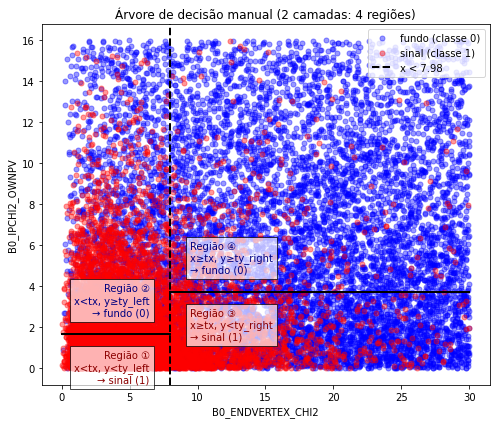

In [4]:
def plot_decision_tree2(x, y, t, tx, ty_left, ty_right):
    plt.figure(figsize=(7,6))

    # Pontos reais
    plt.scatter(x[t==0], y[t==0], c='blue', s=25, label='fundo (classe 0)', alpha=0.4)
    plt.scatter(x[t==1], y[t==1], c='red',  s=25, label='sinal (classe 1)', alpha=0.4)

    # Fronteiras
    plt.axvline(tx, color='k', lw=2, ls='--', label=f"x < {tx:.2f}")
    plt.plot([np.min(x), tx], [ty_left, ty_left],  color='k', lw=2)
    plt.plot([tx, np.max(x)], [ty_right, ty_right], color='k', lw=2)

    # Texto explicativo: 4 regiões
    dx = 0.05 * (np.max(x) - np.min(x))
    dy = 0.05 * (np.max(y) - np.min(y))

    plt.text(tx - dx, ty_left - dy, 
             "Região ①\nx<tx, y<ty_left\n→ sinal (1)", 
             ha='right', va='top', color='darkred',
             bbox=dict(facecolor='white', alpha=0.7))

    plt.text(tx - dx, ty_left + dy, 
             "Região ②\nx<tx, y≥ty_left\n→ fundo (0)", 
             ha='right', va='bottom', color='navy',
             bbox=dict(facecolor='white', alpha=0.7))

    plt.text(tx + dx, ty_right - dy, 
             "Região ③\nx≥tx, y<ty_right\n→ sinal (1)", 
             ha='left', va='top', color='darkred',
             bbox=dict(facecolor='white', alpha=0.7))

    plt.text(tx + dx, ty_right + dy, 
             "Região ④\nx≥tx, y≥ty_right\n→ fundo (0)", 
             ha='left', va='bottom', color='navy',
             bbox=dict(facecolor='white', alpha=0.7))

    # Labels e título
    plt.xlabel(X1)
    plt.ylabel(X2)
    plt.legend(loc='upper right')
    plt.title("Árvore de decisão manual (2 camadas: 4 regiões)")
    plt.tight_layout()
    plt.show()

    
plot_decision_tree2(x, y, t, tx, ty_left, ty_right)

# (d) Ajustar manualmente os cortes

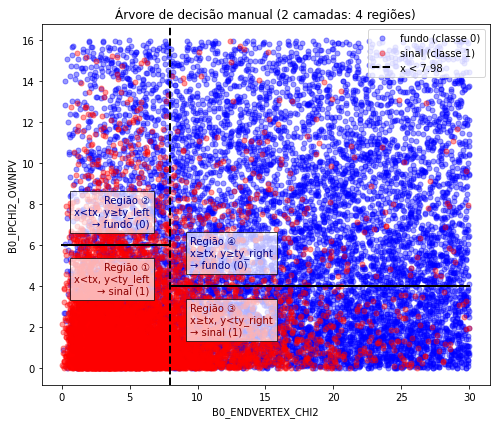

In [5]:
tx_man  = np.median(x)
tyL_man = 6.0
tyR_man = 4.0
pred_manual = predict_tree_2layers(x, y, tx_man, tyL_man, tyR_man, low_y_is_signal=True)

plot_decision_tree2(x, y, t, tx_man, tyL_man, tyR_man)

# (e) Calcular a eficiência de sinal e rejeição de background

In [6]:
def compute_eff_rej_simple(y_true, y_pred):
    """
    Calcula:
      - Eficiência de sinal: fração de eventos sinal corretamente classificados.
      - Rejeição de fundo: fração de eventos fundo corretamente rejeitados.
    Tudo feito 'na mão', sem usar confusion_matrix.
    """
    # índices de cada classe
    sig_idx = (y_true == 1)
    bkg_idx = (y_true == 0)

    # sinal verdadeiro → predito como 1
    tp = np.sum(y_pred[sig_idx] == 1)
    fn = np.sum(y_pred[sig_idx] == 0)

    # fundo verdadeiro → predito como 0
    tn = np.sum(y_pred[bkg_idx] == 0)
    fp = np.sum(y_pred[bkg_idx] == 1)

    eff_signal = tp / (tp + fn) if (tp + fn) > 0 else 0   # TPR
    rej_bkg     = tn / (tn + fp) if (tn + fp) > 0 else 0   # TNR

    return eff_signal, rej_bkg

# calcula para os dois métodos
eff_median, rej_median = compute_eff_rej_simple(t, pred_median)
eff_manual, rej_manual = compute_eff_rej_simple(t, pred_manual)

# mostra os resultados
print(f"--- Cortes por Mediana ---")
print(f"Eficiência de sinal (TPR): {eff_median:.3f}")
print(f"Rejeição de fundo (TNR):  {rej_median:.3f}\n")

print(f"--- Cortes Manuais ---")
print(f"Eficiência de sinal (TPR): {eff_manual:.3f}")
print(f"Rejeição de fundo (TNR):  {rej_manual:.3f}")

--- Cortes por Mediana ---
Eficiência de sinal (TPR): 0.630
Rejeição de fundo (TNR):  0.630

--- Cortes Manuais ---
Eficiência de sinal (TPR): 0.915
Rejeição de fundo (TNR):  0.529


# Extra: Decision tree

In [7]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# 1. preparamos os dados
XY = np.c_[x, y]       # usa as duas variáveis escolhidas
y_true = t             # rótulos verdadeiros (0=fundo, 1=sinal)

# 2. criamos e treinamos a árvore
dt = DecisionTreeClassifier(max_depth=2, random_state=42)
dt.fit(XY, y_true)

# 3. aplicamos a árvore para prever
y_pred = dt.predict(XY)

# 4. calculamos eficiência de sinal e rejeição de fundo
sig_idx = (y_true == 1)
bkg_idx = (y_true == 0)

eff_signal = np.sum(y_pred[sig_idx] == 1) / np.sum(sig_idx)
rej_bkg    = np.sum(y_pred[bkg_idx] == 0) / np.sum(bkg_idx)

# 5. mostramos os resultados
print(f"Eficiência de sinal (TPR): {eff_signal:.3f}")
print(f"Rejeição de fundo (TNR):  {rej_bkg:.3f}")

Eficiência de sinal (TPR): 0.782
Rejeição de fundo (TNR):  0.848


# Exercisio 2

In [8]:
# ====== imports básicos ======
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, classification_report,
                             accuracy_score, ConfusionMatrixDisplay)
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import learning_curve, StratifiedKFold

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ====== caminho do seu CSV ======
CSV_PATH = "/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Combined_10K.csv"
assert os.path.exists(CSV_PATH), f"CSV não encontrado em {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
assert 'label' in df.columns, "CSV precisa conter a coluna 'label' (0=fundo, 1=sinal)."

print(df.shape, "linhas x colunas")
df.head()


(20001, 18) linhas x colunas


,B0_M,B0_P,B0_PT,B0_DIRA_OWNPV,B0_ENDVERTEX_CHI2,B0_TAU,K_PIDK,Pi_PIDK,mu_plus_PIDmu,mu_minus_PIDmu,B0_FDCHI2_OWNPV,B0_IPCHI2_OWNPV,K_IPCHI2_OWNPV,Pi_IPCHI2_OWNPV,mu_plus_IPCHI2_OWNPV,mu_minus_IPCHI2_OWNPV,q2,label
0,5293.991001,75896.203841,8909.803377,0.999999,4.905650,0.001284,90.508797,-46.337502,12.187781,7.432416,3081.747660,0.371431,59.050087,83.338387,1780.312976,28.701731,9.663302,1
1,5288.832014,126115.585086,10691.039729,1.000000,2.004244,0.001243,24.425800,-30.905701,2.919568,6.710679,2156.295071,0.518954,117.929828,16.125493,148.942208,193.719177,9.641775,1
2,5295.424405,114864.557485,2406.324645,0.999998,12.073755,0.002071,28.216801,-18.581900,6.832418,9.504477,2660.020136,2.568881,27.325995,15.858291,1612.783038,468.393934,9.759748,1
3,5269.043465,54960.554640,2282.680501,0.999985,1.617552,0.001040,27.841700,-56.836899,4.109861,8.587584,607.622240,1.330499,80.198100,98.543575,290.049372,65.434165,9.535254,1
4,5283.438848,152677.844241,7923.259410,1.000000,4.073691,0.004821,6.273400,-31.115299,6.782620,10.778706,30945.021839,5.415031,641.926005,318.035248,1603.637163,10081.557016,9.629298,1


# Separar features (X) e alvo (y)

In [9]:
# usamos todas as colunas exceto 'label' e 'B0_M'
num_cols = [c for c in df.columns if c not in ['label', 'B0_M','q2']]
X = df[num_cols].values
y = df['label'].astype(int).values

# informações básicas do dataset
print("n_features:", X.shape[1])
print("features usadas:", num_cols)

n_features: 15
features usadas: ['B0_P', 'B0_PT', 'B0_DIRA_OWNPV', 'B0_ENDVERTEX_CHI2', 'B0_TAU', 'K_PIDK', 'Pi_PIDK', 'mu_plus_PIDmu', 'mu_minus_PIDmu', 'B0_FDCHI2_OWNPV', 'B0_IPCHI2_OWNPV', 'K_IPCHI2_OWNPV', 'Pi_IPCHI2_OWNPV', 'mu_plus_IPCHI2_OWNPV', 'mu_minus_IPCHI2_OWNPV']


# Funções auxiliares

In [10]:
def plot_corr_heatmap(df_num, title="Correlação (Pearson)"):
    C = np.corrcoef(df_num.T)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(C, vmin=-1, vmax=1)
    ax.set_title(title)
    ax.set_xticks(range(len(df_num.columns))); ax.set_xticklabels(df_num.columns, rotation=90, fontsize=8)
    ax.set_yticks(range(len(df_num.columns))); ax.set_yticklabels(df_num.columns, fontsize=8)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

def plot_learning_curve(estimator, X, y,
                               cv_splits=5,
                               scoring='accuracy',
                               train_sizes=np.linspace(0.3, 1.0, 5),
                               random_state=42):
    """
    Gera uma curva de aprendizado simples com estratificação e métrica de acurácia.
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=cv,
        train_sizes=train_sizes,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=random_state
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.figure()
    plt.plot(sizes, train_mean, label="Treino", marker='o')
    plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.plot(sizes, val_mean, label="Validação", marker='s')
    plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
    plt.xlabel("Tamanho do conjunto de treino")
    plt.ylabel(scoring.capitalize())
    plt.title("Curva de aprendizado")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_performance(clf, X_train, y_train, X_test, y_test, bins=40, invert=False, title="TMVA-like"):
    """
    Plot do score do classificador para S/B em treino e teste.
    """
    # Scores = probabilidade de ser sinal (classe 1)
    s_tr = clf.predict_proba(X_train)[:, 1]
    s_te = clf.predict_proba(X_test)[:, 1]
    if invert:
        s_tr = 1.0 - s_tr
        s_te = 1.0 - s_te

    # separa por classe
    s_tr_sig = s_tr[y_train == 1]; s_tr_bkg = s_tr[y_train == 0]
    s_te_sig = s_te[y_test  == 1]; s_te_bkg = s_te[y_test  == 0]

    # bins comuns (0..1)
    edges = np.linspace(0, 1, bins + 1)

    plt.figure(figsize=(7,4.5))
    # Treino preenchido
    plt.hist(s_tr_sig, bins=edges, alpha=0.35, label="S (train)", color="tab:red")
    plt.hist(s_tr_bkg, bins=edges, alpha=0.35, label="B (train)", color="tab:blue")
    # Teste como linha (ou pontos)
    plt.hist(s_te_sig, bins=edges, histtype="step", linewidth=1.8, label="S (test)", color="tab:red")
    plt.hist(s_te_bkg, bins=edges, histtype="step", linewidth=1.8, label="B (test)", color="tab:blue")

    plt.xlabel("Classifier output (score de sinal)")
    plt.ylabel("Counts / bin")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_roc_with_auc(model, X_test, y_test, name="Modelo"):
    """
    Plota a curva ROC e escreve o valor do AUC dentro do gráfico.
    Supõe que o modelo já foi treinado.
    """
    # obtém a pontuação do classificador (probabilidade da classe 1)
    y_score = model.predict_proba(X_test)[:, 1]

    # calcula FPR, TPR e AUC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)

    # plota
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{name}")
    plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=1)
    plt.xlabel("Taxa de falsos positivos (FPR)")
    plt.ylabel("Taxa de verdadeiros positivos (TPR)")
    plt.title("Curva ROC")

    # adiciona o valor do AUC dentro do gráfico
    plt.text(0.65, 0.15, f"AUC = {auc:.3f}",
             transform=plt.gca().transAxes,
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

    plt.legend()
    plt.tight_layout()
    plt.show()
    return auc



# 1) Decision Tree (modelo base)

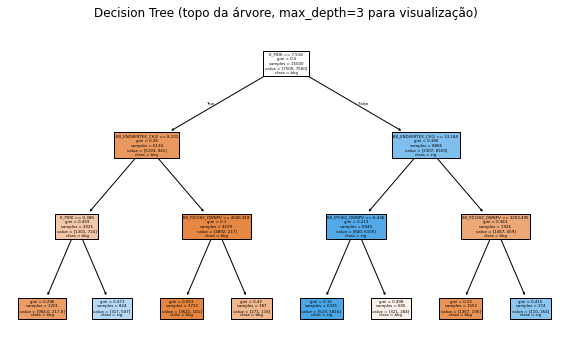

In [27]:
# split estável
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

# árvore simples com hiperparâmetros default
#dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=50,random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

# Apenas para mostrar 1 vez
plt.figure(figsize=(10,6))
plot_tree(dt, max_depth=3, filled=True, feature_names=num_cols, class_names=["bkg","sig"])
plt.title("Decision Tree (topo da árvore, max_depth=3 para visualização)")
plt.show()


# 2 - Métricas e gráficos de análise

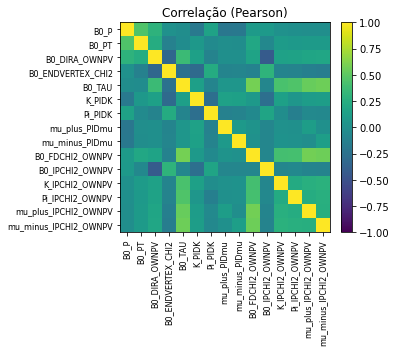

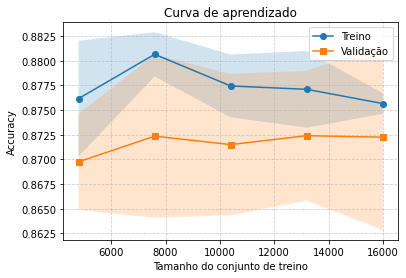

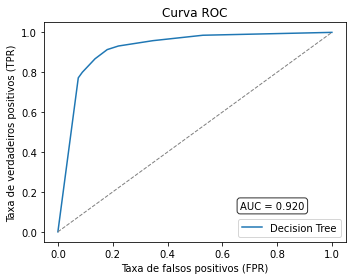

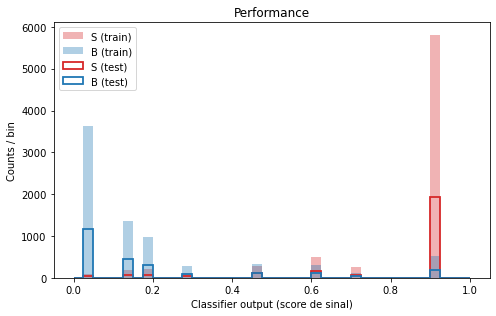

In [28]:
# (a) Correlação entre variáveis
plot_corr_heatmap(df[num_cols])

# (b) Learning curve (usamos AUC como métrica)
plot_learning_curve(dt, X, y)

# (c) Plot ROC curve
plot_roc_with_auc(dt, X_test, y_test, name="Decision Tree")

# (d) plot treino/validacao
plot_performance(dt, X_train, y_train, X_test, y_test, bins=40, invert=False, title="Performance")